In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import catboost
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, GridSearchCV 
from sklearn.feature_selection import RFECV, SelectFromModel
from tabulate import tabulate


import datetime

newparams = {'figure.figsize': (12, 8), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}

plt.rcParams.update(newparams)

In [8]:
data_path="../data/"

folders = ["A", "B", "C"]


dataframes = {f : {} for f in folders}
for folder in folders:
    for file in os.listdir(data_path + folder + "/"):
        filename=file.split(".")[0]
        dataframes[folder][filename]=pd.read_parquet(data_path + folder + "/"+ file)


In [9]:
def site_to_num(site):
    if site not in ["A", "B", "C"]:
        raise Exception("site must be A, B or C")
    elif site=="A":
        return 1
    elif site=="B":
        return 2
    elif site=="C":
        return 3
    
def merge_frames(dataframes):
    to_concat=[]

    for site in dataframes.keys():
        for column in ["X_train_observed", "X_train_estimated"]:
            df_to_add=pd.merge(left=dataframes[site]["train_targets"], right=dataframes[site][column], left_on="time", right_on="date_forecast")
            df_to_add["site"]=site_to_num(site)
            to_concat.append(df_to_add.copy())

    df = pd.concat(to_concat, ignore_index=True)
    
    return df.dropna(subset=["pv_measurement"])

In [10]:
X_frames=[]
Y_frames=[]

for site in dataframes.keys():
    for frame in dataframes[site].keys():
        if "X" in frame:
            to_append=dataframes[site][frame]
            to_append["site"] = site_to_num(site)
            X_frames.append(to_append)
        else:
            to_append=dataframes[site][frame].copy()
            to_append["site"] = site_to_num(site)
            Y_frames.append(to_append)

In [11]:
rolling_cols= []
non_rolling_cols = []

for col in X_frames[0].columns:
    var = X_frames[0][col].std()
    if col in ["date_forecast", "date_calc"]:
        continue
    if var > 0:
        rolling_cols.append(col)
    else:
        non_rolling_cols.append(col)

print(non_rolling_cols)

['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'wind_speed_w_1000hPa:ms', 'site']


In [12]:
window_sizes = []


for frame_dict in dataframes.values():
    for frame_name, frame in frame_dict.items():
        if "X" not in frame_name:
            continue

        for size in window_sizes:
            for col in rolling_cols:
                if "idx" in col:
                    continue
                col_name=f"{col}_rm_{size}"
                frame[col_name]=frame[col].rolling(window=size).mean()

                col_name=f"{col}_rstd_{size}"
                frame[col_name]=frame[col].rolling(window=size).std()



In [13]:
df = merge_frames(dataframes)
df

time  pv_measurement       date_forecast  \
0     2019-06-02 22:00:00            0.00 2019-06-02 22:00:00   
1     2019-06-02 23:00:00            0.00 2019-06-02 23:00:00   
2     2019-06-03 00:00:00            0.00 2019-06-03 00:00:00   
3     2019-06-03 01:00:00            0.00 2019-06-03 01:00:00   
4     2019-06-03 02:00:00           19.36 2019-06-03 02:00:00   
...                   ...             ...                 ...   
99009 2023-04-30 19:00:00           50.96 2023-04-30 19:00:00   
99010 2023-04-30 20:00:00            2.94 2023-04-30 20:00:00   
99011 2023-04-30 21:00:00            0.00 2023-04-30 21:00:00   
99012 2023-04-30 22:00:00           -0.00 2023-04-30 22:00:00   
99013 2023-04-30 23:00:00           -0.00 2023-04-30 23:00:00   

       absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
0                           7.7                1.230           1744.900024   
1                           7.7                1.225           1703.599976   
2                           7.7                1.221           1668.099976   
3                           8.2                1.218           1388.400024   
4                           8.8                1.219           1108.500000   
...                         ...                  ...                   ...   
99009                       4.4                1.274           1474.199951   
99010                       4.4                1.278           1427.300049   
99011                       4.4                1.279           1558.099976   
99012                       4.4                1.279           1446.599976   
99013                       4.4                1.280            897.200012   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
0                   0.000000              0.0       1744.900024   
1                   0.000000              0.0       1703.599976   
2                   0.000000              0.0       1668.099976   
3                   0.000000              0.0       1388.400024   
4                6546.899902              9.8       1108.500000   
...                      ...              ...               ...   
99009          156770.703125             13.4        557.000000   
99010            7917.100098              0.0        541.700012   
99011               0.000000              0.0        601.500000   
99012               0.000000              0.0        540.700012   
99013               0.000000              0.0        569.500000   

       dew_or_rime:idx  ...  super_cooled_liquid_water:kgm2  t_1000hPa:K  \
0                  0.0  ...                             0.0   285.899994   
1                  0.0  ...                             0.0   286.799988   
2                  0.0  ...                             0.0   287.000000   
3                  0.0  ...                             0.0   286.899994   
4                  0.0  ...                             0.0   286.500000   
...                ...  ...                             ...          ...   
99009              0.0  ...                             0.0   275.100006   
99010              0.0  ...                             0.0   274.600006   
99011              0.0  ...                             0.0   274.500000   
99012              0.0  ...                             0.1   274.299988   
99013              0.0  ...                             0.2   274.100006   

       total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0               100.000000  39640.101562                3.7   
1               100.000000  41699.898438                3.5   
2               100.000000  20473.000000                3.2   
3               100.000000   2104.600098                2.8   
4               100.000000   2681.600098                2.7   
...                    ...           ...                ...   
99009            98.599998  27493.599609                4.3   
99010            97.400002  20912.300781                3.6   
99011            9

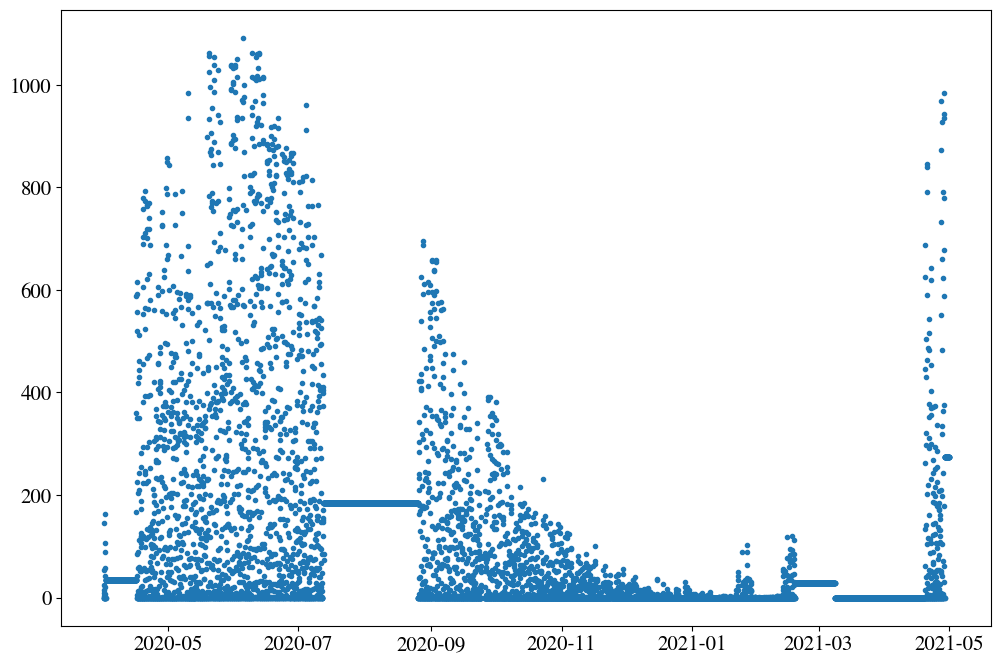

In [14]:
Y_col="pv_measurement"

df_B=df[df["site"]==site_to_num("B")]

filter_all=(df_B["date_forecast"] > "2020-4-1")& (df_B["date_forecast"] < "2021-5-1")
filter_1=(df_B["date_forecast"] > "2021-3-1")& (df_B["date_forecast"] < "2021-4-20")

df_B=df_B[filter_all]
plt.plot(df_B["date_forecast"], df_B[Y_col], ".")

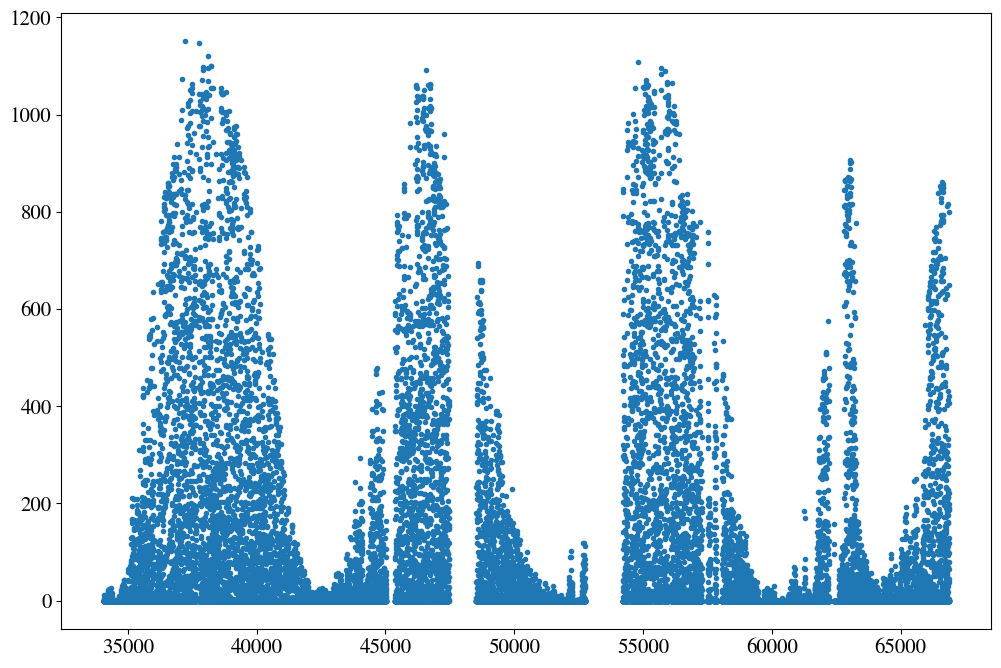

In [16]:
mask = (df[Y_col] == df[Y_col].shift(1)) & df[Y_col]!=0

mask2 = ((df["date_forecast"] > "2021-3-1") & (df["date_forecast"] < "2021-4-20")) 

df=df[~mask]
df=df[~mask2]

plt.plot(df[df["site"]==site_to_num("B")][Y_col], ".")

In [17]:
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour
df["date_calc"]
df["date_calc"]= df["date_calc"].fillna(df["date_forecast"])
df["date_difference"] = df["date_forecast"]-df["date_calc"]

df["date_difference"] = df["date_difference"] / pd.Timedelta(hours=1)


In [18]:
not_X_cols=["time", "pv_measurement", "date_forecast", "date_calc"]
df.columns
X_cols=["month", "day", "hour", "date_difference"]

for col in dataframes["A"]["X_train_observed"].columns:
    if col not in not_X_cols:
        X_cols.append(col)

Y_col="pv_measurement"

X_cols_new = []

remove_non_rolling = [col for col in non_rolling_cols if col != "site"]

remove_cols= [] # <--- Add columns to remove here

remove_words = ["snow", "wind", "precip", "pressure"] # <-- Add keywords to remove here




for col in X_cols:
    for word in remove_words:
        if word in col:
            remove_cols.append(col)

for col in X_cols:
    if not col in remove_cols:
        X_cols_new.append(col)
    

X_cols = X_cols_new


# 

In [23]:
for col in X_cols:
    print(col)

month
day
hour
date_difference
absolute_humidity_2m:gm3
air_density_2m:kgm3
ceiling_height_agl:m
clear_sky_energy_1h:J
clear_sky_rad:W
cloud_base_agl:m
dew_or_rime:idx
dew_point_2m:K
diffuse_rad:W
diffuse_rad_1h:J
direct_rad:W
direct_rad_1h:J
effective_cloud_cover:p
elevation:m
is_day:idx
is_in_shadow:idx
msl_pressure:hPa
precip_5min:mm
precip_type_5min:idx
pressure_100m:hPa
pressure_50m:hPa
prob_rime:p
rain_water:kgm2
relative_humidity_1000hPa:p
sfc_pressure:hPa
sun_azimuth:d
sun_elevation:d
super_cooled_liquid_water:kgm2
t_1000hPa:K
total_cloud_cover:p
visibility:m
site


In [25]:
for col in X_cols:
    df[col] = df.groupby("time")[col].ffill().bfill()

df["snow_density:kgm3"]=df["snow_density:kgm3"].fillna(0)


In [26]:
df

time  pv_measurement       date_forecast  \
0     2019-06-02 22:00:00            0.00 2019-06-02 22:00:00   
1     2019-06-02 23:00:00            0.00 2019-06-02 23:00:00   
2     2019-06-03 00:00:00            0.00 2019-06-03 00:00:00   
3     2019-06-03 01:00:00            0.00 2019-06-03 01:00:00   
4     2019-06-03 02:00:00           19.36 2019-06-03 02:00:00   
...                   ...             ...                 ...   
99009 2023-04-30 19:00:00           50.96 2023-04-30 19:00:00   
99010 2023-04-30 20:00:00            2.94 2023-04-30 20:00:00   
99011 2023-04-30 21:00:00            0.00 2023-04-30 21:00:00   
99012 2023-04-30 22:00:00           -0.00 2023-04-30 22:00:00   
99013 2023-04-30 23:00:00           -0.00 2023-04-30 23:00:00   

       absolute_humidity_2m:gm3  air_density_2m:kgm3  ceiling_height_agl:m  \
0                           7.7                1.230           1744.900024   
1                           7.7                1.225           1703.599976   
2                           7.7                1.221           1668.099976   
3                           8.2                1.218           1388.400024   
4                           8.8                1.219           1108.500000   
...                         ...                  ...                   ...   
99009                       4.4                1.274           1474.199951   
99010                       4.4                1.278           1427.300049   
99011                       4.4                1.279           1558.099976   
99012                       4.4                1.279           1446.599976   
99013                       4.4                1.280            897.200012   

       clear_sky_energy_1h:J  clear_sky_rad:W  cloud_base_agl:m  \
0                   0.000000              0.0       1744.900024   
1                   0.000000              0.0       1703.599976   
2                   0.000000              0.0       1668.099976   
3                   0.000000              0.0       1388.400024   
4                6546.899902              9.8       1108.500000   
...                      ...              ...               ...   
99009          156770.703125             13.4        557.000000   
99010            7917.100098              0.0        541.700012   
99011               0.000000              0.0        601.500000   
99012               0.000000              0.0        540.700012   
99013               0.000000              0.0        569.500000   

       dew_or_rime:idx  ...  wind_speed_10m:ms  wind_speed_u_10m:ms  \
0                  0.0  ...                3.7                 -3.6   
1                  0.0  ...                3.5                 -3.5   
2                  0.0  ...                3.2                 -3.1   
3                  0.0  ...                2.8                 -2.7   
4                  0.0  ...                2.7                 -2.5   
...                ...  ...                ...                  ...   
99009              0.0  ...                4.3                  3.9   
99010              0.0  ...                3.6                  3.1   
99011              0.0  ...                3.6                  2.7   
99012              0.0  ...                3.5                  2.6   
99013              0.0  ...                2.8                  1.9   

       wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  site           date_calc  \
0                     -0.8                     -0.0     1 2019-06-02 22:00:00   
1                      0.0                     -0.0     1 2019-06-02 23:00:00   
2                      0.7                     -0.0     1 2019-06-03 00:00:00   
3                      0.8                     -0.0     1 2019-06-03 01:00:00   
4                      1.0                     -0.0     1 2019-06-03 02:00:00   
...                    ...                      ...   ...                 ...   
99009                  1.8                     -0.0     3 2023-04-29 07:00:05 